# How to use QRydDemo's emulator with Qoqo?

Accessing [QRydDemo](https://thequantumlaend.de/qryddemo/)'s emulator with [Qoqo](https://github.com/HQSquantumsimulations/qoqo) is supported by the software package [qoqo-qryd](https://github.com/HQSquantumsimulations/qoqo_qryd) developed by [HQS Quantum Simulations](https://quantumsimulations.de/). The software is designed to enable the excution of quantum algorithms implemented in Qoqo on the hardware of the QRydDemo consortium. Qoqo is a circuit based quantum computing toolkit. Like many other quantum computing toolkits, it can be used to construct quantum circuits sequences of quantum operations that are to be executed on a quantum computer or on an emulator.

The python package `qoqo-qryd`, that enables accessing QRydDemo's emulator with Qoqo, can be installed via the Python package manager pip

```bash
> pip install qoqo-qryd
```

In the following, we demonstrate how users can execute arbitrary quantum algorithms on QRydDemo's emulator, using the example of a quantum Fourier transform. On our servers, a decomposer developed by HQS Quantum Simulations compiles quantum algorithms to the gate set and connectivities supported by the emulator and future Rydberg quantum computer.

<font color='red'>*You can adapt and execute this notebook to run your own calculations on our servers (Menu Bar > Run > Run All Cells), without having to install qoqo-qryd. However, the notebook will be reset at 00:00 CET/CEST and all your changes will be lost. Thus, please make sure to download your notebook and save it locally.*</font>

**Currently supported Rydberg gates:**
* Phase shift of the qubit state |1>
* Rotation around an arbitrary axis in the x-, y-, z- and xy-plane
* Square-root of X gate as well as its Inverse
* Phase-shifted CZ-gate (a Rydberg variant of the CZ-gate \[[1](https://doi.org/10.1103/PhysRevLett.123.170503), [2](https://arxiv.org/abs/2202.13849)\])
* Phase-shifted CP-gate

**Currently supported connectivities:**
<table align=left><tr>
<td> <img src="square.png" alt="Square lattice with nearest-neighbor connectivity" style="width: 300px;"/> </td>
<td> <img src="triangle.png" alt="Triangle lattice with nearest-neighbor connectivity" style="width: 300px;"/> </td>
</tr></table>

## 1. Basic usage

### Initialize the QRydDemo access

To initialize the access, a QRydDemo API token is required. The token can be obtained via the registration form at [thequantumlaend.de](https://thequantumlaend.de/frontend/signup_form.php).
For convenience, your token has already been loaded into this notebook.

In [1]:
import os

token = os.getenv("QRYD_API_TOKEN")


### Choose a backend

Different layouts are available for the API backend that are capable of running ideal simulations of quantum circuits. An inclusion of noise models is planned for the future via the `TweezerDevice` instance. You can either choose a layout emulating 30 qubits arranged in a 5x6 square lattice with nearest-neighbor connectivity (`square` layout) or in a triangle lattice (`triangle`). The transpilation of arbitrary quantum algorithms to these connectivities and the gate set of the Rydberg platform happens on our servers, using a decomposer developed by [HQS Quantum Simulations](https://quantumsimulations.de/).

In [2]:
from qoqo_qryd import APIBackend
from qoqo_qryd.tweezer_devices import TweezerDevice
import numpy as np

device = TweezerDevice().from_api()
print("Available layouts: ", device.available_layouts())

device.switch_layout("triangle")
print("Switch to the triangular layout.")

backend = APIBackend(
    device=device, access_token=token, timeout=30
)  # timeout in seconds, 30s per default

Available layouts:  ['square', 'triangle']
Switch to the triangular layout.


### Create a quantum algorithm

You can use the gate operations provided by Qoqo to create a quantum algorithm, e.g., in the following, we create a quantum circuit that calculates the Fourier transform of a rectangular function.

In [3]:
from qoqo import Circuit
from qoqo import operations as ops
import numpy as np


def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit += ops.Hadamard(qubit=n)
    for qubit in range(n):
        circuit += ops.ControlledPhaseShift(
            control=qubit, target=n, theta=np.pi / 2 ** (n - qubit)
        )

    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)


def swap_registers(circuit, n):
    """Performs the swap part of the QFT algorithm"""
    for qubit in range(n // 2):
        circuit += ops.SWAP(control=qubit, target=n - qubit - 1)
    return circuit


def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit


# Create a quantum circuit object
num_qubits = 4
qc = Circuit()

# Add a register to store the measurement to the Circuit
qc += ops.DefinitionBit(name="ro", length=num_qubits, is_output=True)

# Encode the state |0>+|1>+|2>+|3>=|0000>+|0001>+|0010>+|0011> (i.e. a state that corresponds
# to a rectangular function in the context of the qft), apply the qft, and measure all qubits
qc += ops.Hadamard(0)
qc += ops.Hadamard(1)
qft(qc, num_qubits)

# Add a measurement operation to the Circuit, here a PragmaRepeatedMeasurement operation valid on QRydDemos's emulator
for i in range(num_qubits):
    qc += ops.MeasureQubit(i, "ro", i)
qc += ops.PragmaSetNumberOfMeasurements(1000, readout="ro")

# Print the resulting quantum circuit
print(qc)

DefinitionBit(DefinitionBit { name: "ro", length: 4, is_output: true })
Hadamard(Hadamard { qubit: 0 })
Hadamard(Hadamard { qubit: 1 })
Hadamard(Hadamard { qubit: 3 })
ControlledPhaseShift(ControlledPhaseShift { control: 0, target: 3, theta: Float(0.39269908169872414) })
ControlledPhaseShift(ControlledPhaseShift { control: 1, target: 3, theta: Float(0.7853981633974483) })
ControlledPhaseShift(ControlledPhaseShift { control: 2, target: 3, theta: Float(1.5707963267948966) })
Hadamard(Hadamard { qubit: 2 })
ControlledPhaseShift(ControlledPhaseShift { control: 0, target: 2, theta: Float(0.7853981633974483) })
ControlledPhaseShift(ControlledPhaseShift { control: 1, target: 2, theta: Float(1.5707963267948966) })
Hadamard(Hadamard { qubit: 1 })
ControlledPhaseShift(ControlledPhaseShift { control: 0, target: 1, theta: Float(1.5707963267948966) })
Hadamard(Hadamard { qubit: 0 })
SWAP(SWAP { control: 0, target: 3 })
SWAP(SWAP { control: 1, target: 2 })
MeasureQubit(MeasureQubit { qubit: 0, reado

### Run the circuit on the emulator

You can execute a `Circuit` object on our cloud emulator by running `backend.run_circuit(qc)`. Alternatively, you can create and run a `QuantumProgram` object by `program.run(backend)`.

In [4]:
%%time

from qoqo.measurements import ClassicalRegister
from qoqo import QuantumProgram
from time import sleep

# Alternativ 1: Run the circuit (unused in this example)
# (result_bit_registers, result_float_registers, result_complex_registers) = backend.run_circuit(qc)

# Alternativ 2: Run the program (followed up in this example)
measurement = ClassicalRegister(circuits=[qc], constant_circuit=None)
program = QuantumProgram(
    measurement=measurement, input_parameter_names=[]
)  # free parameters not yet allowed on QRydDemo's emulator
job = backend.post_job(program)

# Show status of the job
while True:
    job_status = backend.get_job_status(job)["status"]
    print(f"Job status: {job_status}                   ", end="\r")
    if job_status in ["completed", "cancelled", "error"]:
        break
    sleep(0.2)

# Get result and show execution time of the circuit on the emulator
result = backend.get_job_result(job)
print(f"Execution time: {result['time_taken']:.4f} s")

Execution time: 0.0012 s                
CPU times: user 8.93 ms, sys: 5.07 ms, total: 14 ms
Wall time: 307 ms


In the following, we plot the measured probabilities as a histogram. The probabilities follow the distribution $|\sin(x)/x|^2$ as we calculated the Fourier transform of a rectangular function.

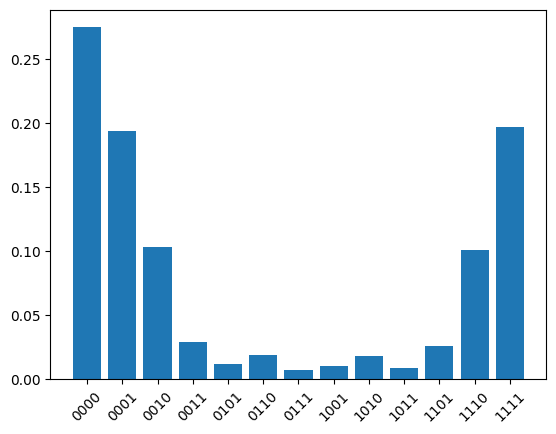

In [5]:
# Plot the results
import matplotlib.pyplot as plt
import collections

counts = result["data"]["counts"]
new_counts = {}
total_counts = np.sum([c for c in counts.values()])
for key, val in counts.items():
    new_key = bin(int(key[2:], base=16))[2:]
    new_key = "{}{}".format("0" * (4 - len(new_key)), new_key)
    new_counts[new_key] = val / total_counts
new_counts = collections.OrderedDict(sorted(new_counts.items()))
fig, ax = plt.subplots()
ax.set_xticks(range(len(new_counts)))
ax.set_xticklabels(new_counts.keys(), rotation=45)
plt.bar(new_counts.keys(), new_counts.values())
plt.show()

Details on the job result object can be accessed by key words, for example:

In [6]:
print(f"Number of executed single-qubit gates: {result['executed_single_qubit_gates']}")
print(f"Number of executed two-qubit gates: {result['executed_two_qubit_gates']}")
print(f"Number of gates after gate fusion: {result['fusion_generated_gates']}")

Number of executed single-qubit gates: 27
Number of executed two-qubit gates: 15
Number of gates after gate fusion: 1


## Run general measurements with qoqo

The quantum computing toolkit qoqo supports executing more general measurements than a simple ClassicalRegister measurement that returns the number of measurement outcomes for each qubit (see also the qoqo_qryd [user documentation](https://hqsquantumsimulations.github.io/qoqo_qryd/)).

As an example we will demonstrate how to measure an expectation value after applying the QFT. The expectation value will be the product of the Z-PauliOperator on qubits 1 and 2.

In [7]:
from qoqo import Circuit
from qoqo import operations as ops
from qoqo.measurements import PauliZProduct, PauliZProductInput
from qoqo import QuantumProgram


# The QFT circuit is setup like before
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit += ops.Hadamard(qubit=n)
    for qubit in range(n):
        circuit += ops.ControlledPhaseShift(
            control=qubit, target=n, theta=np.pi / 2 ** (n - qubit)
        )

    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)


def swap_registers(circuit, n):
    """Performs the swap part of the QFT algorithm"""
    for qubit in range(n // 2):
        circuit += ops.SWAP(control=qubit, target=n - qubit - 1)
    return circuit


def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit


# Create a quantum circuit object
num_qubits = 4
qc = Circuit()

# Add a register to store the measurement to the Circuit
qc += ops.DefinitionBit(name="ro", length=num_qubits, is_output=True)

# Encode the state |0>+|1>+|2>+|3>=|0000>+|0001>+|0010>+|0011> (i.e. a state that corresponds
# to a rectangular function in the context of the qft), apply the qft, and measure all qubits
qc += ops.Hadamard(0)
qc += ops.Hadamard(1)
qft(qc, num_qubits)

# Add a measurement operation to the Circuit
for i in range(num_qubits):
    qc += ops.MeasureQubit(i, "ro", i)
qc += ops.PragmaSetNumberOfMeasurements(1000, readout="ro")

# We now use qoqo's PauliZProduct measurement to measure the expectation value

# Preparing the measurement input for four qubits
measurement_input = PauliZProductInput(4, False)

# Read out product of Z on site 1 and site 2 for register ro (no basis change)
index = measurement_input.add_pauliz_product("ro", [1, 2])

# Add a result (the expectation value of the product) that is a combination of the PauliProduct expectation values
measurement_input.add_linear_exp_val("<Z1Z2>", {index: 10.0})

measurement = PauliZProduct(
    constant_circuit=None,
    circuits=[qc],
    input=measurement_input,
)

# Creating the backend
device = TweezerDevice().from_api()
device.switch_layout("triangle")
backend = APIBackend(
    device=device, access_token=token, timeout=30
)  # timeout in seconds, 30s per default

# In the following, we show two alternative options that can be run and that are equivalent for our use case:

# a) Running the measurement
expecation_values = backend.run_measurement(measurement)
print(expecation_values)

# b) Run a quantum program (the QuantumProgram has no free parameter, in the current version of the WebAPI free parameters are not supported)
program = QuantumProgram(measurement=measurement, input_parameter_names=[])
expecation_values = program.run(backend, [])
print(expecation_values)

{'<Z1Z2>': 5.72}
{'<Z1Z2>': 6.3}


## Qubit shifts example

The following script demonstrates a shift operation using PragmaShiftQubitsTweezers.

The first circuit fails upon execution because qubits 1 and 2 are initially located in tweezer positions 1 and 4, respectively.
The second circuit includes an additional shift operation, which repositions qubits 2 and 3 in the correct configuration. This adjustment enables the PhaseShiftedControlledZ operation to execute successfully.

In [8]:
import numpy as np
import qoqo.operations as ops  # type:ignore
from qoqo import Circuit
from qoqo_qryd import SimulatorBackend
from qoqo_qryd import pragma_operations as qrydops
from qoqo_qryd.tweezer_devices import TweezerMutableDevice  # type:ignore
from utils import apply_column_square, apply_row

# ------------------------- The set-up of the device -------------------------- #

# Initializing Device with a square lattice
#
#   Tweezer positions:
#   0 ----- 1 ----- 2 ----- 3
#   4 ----- 5 ----- 6 ----- 7
#
#   Qubit positions:
#   0 --- 1
#   2 --- 3
#
rows = 2
columns = 4

device = TweezerMutableDevice()
device.add_layout("square_lattice")

for i in range(rows * columns):
    for gate in ["RotateX", "PhaseShiftState1"]:
        device.set_tweezer_single_qubit_gate_time(gate, i, 1.0, "square_lattice")

for row in range(rows):
    for column in range(columns):
        row_indices = apply_row(row, column, columns, rows)
        column_indices = apply_column_square(row, column, columns, rows)
        if row_indices is not None:
            device.set_tweezer_two_qubit_gate_time(
                "PhaseShiftedControlledZ",
                row_indices[0],
                row_indices[1],
                1.0,
                "square_lattice",
            )
        if column_indices is not None:
            device.set_tweezer_two_qubit_gate_time(
                "PhaseShiftedControlledZ",
                column_indices[0],
                column_indices[1],
                1.0,
                "square_lattice",
            )

device.set_allowed_tweezer_shifts_from_rows(
    [[0, 1, 2, 3], [4, 5, 6, 7]], "square_lattice"
)

device.switch_layout("square_lattice", with_trivial_map=False)

# Populate the device according to initialization explained above
device.add_qubit_tweezer_mapping(0, 0)
device.add_qubit_tweezer_mapping(1, 1)
device.add_qubit_tweezer_mapping(2, 4)
device.add_qubit_tweezer_mapping(3, 5)

backend = SimulatorBackend(device)

# ------------------------ The set-up of the circuit (incorrect) ------------------------ #

circuit = Circuit()
# Qubits 1 and 2 are not close enough for interaction in square lattice
circuit += ops.PhaseShiftedControlledZ(control=1, target=2, phi=0.0)
# This should fail
# result = backend.run_circuit(circuit)


# ------------------ The set-up of the circuit (correct) --------------- #

circuit = Circuit()
# Qubits 1 and 2 are close enough for interaction in square lattice after shift
#   Qubit positions after shift:
#   0 --- 1
#         2 --- 3
circuit += ops.DefinitionComplex("state_vector_before", 16, True)
circuit += ops.DefinitionComplex("state_vector_after", 16, True)
circuit += ops.RotateX(1, np.pi)
circuit += ops.RotateX(2, np.pi / 2)
circuit += ops.PragmaGetStateVector("state_vector_before", None)
circuit += qrydops.PragmaShiftQubitsTweezers([(5, 6), (4, 5)]).to_pragma_change_device()
circuit += ops.PhaseShiftedControlledZ(control=1, target=2, phi=0.0)
circuit += ops.PragmaGetStateVector("state_vector_after", None)
# This should pass
result = backend.run_circuit(circuit)
print("State vector before applying shift and two-qubit gate")
print(result[2]["state_vector_before"])
print("State vector after applying shift and two-qubit gate")
print(result[2]["state_vector_after"])

State vector before applying shift and two-qubit gate
[[(4.329780281177467e-17+0j), 0j, -0.7071067811865476j, 0j, -4.329780281177466e-17j, 0j, (-0.7071067811865475+0j), 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j]]
State vector after applying shift and two-qubit gate
[[(4.329780281177467e-17+0j), 0j, -0.7071067811865476j, 0j, -4.329780281177466e-17j, 0j, (0.7071067811865475-8.659560562354932e-17j), 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j]]
